In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [107]:
sample = pd.read_excel("Health_Sample dataset_SBP by month (1).xlsx").iloc[:, 1: ]
df = pd.read_excel("iHealth Time Series - v1.xlsx")

## Exploratary Data Analysis

In [15]:
# number of the unique patient in the sample data
len(sample["memberId"].unique())

246

/var/folders/wp/6_zz4vgs79ndjls9bw_j54s80000gn/T/ipykernel_98719/3647028103.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


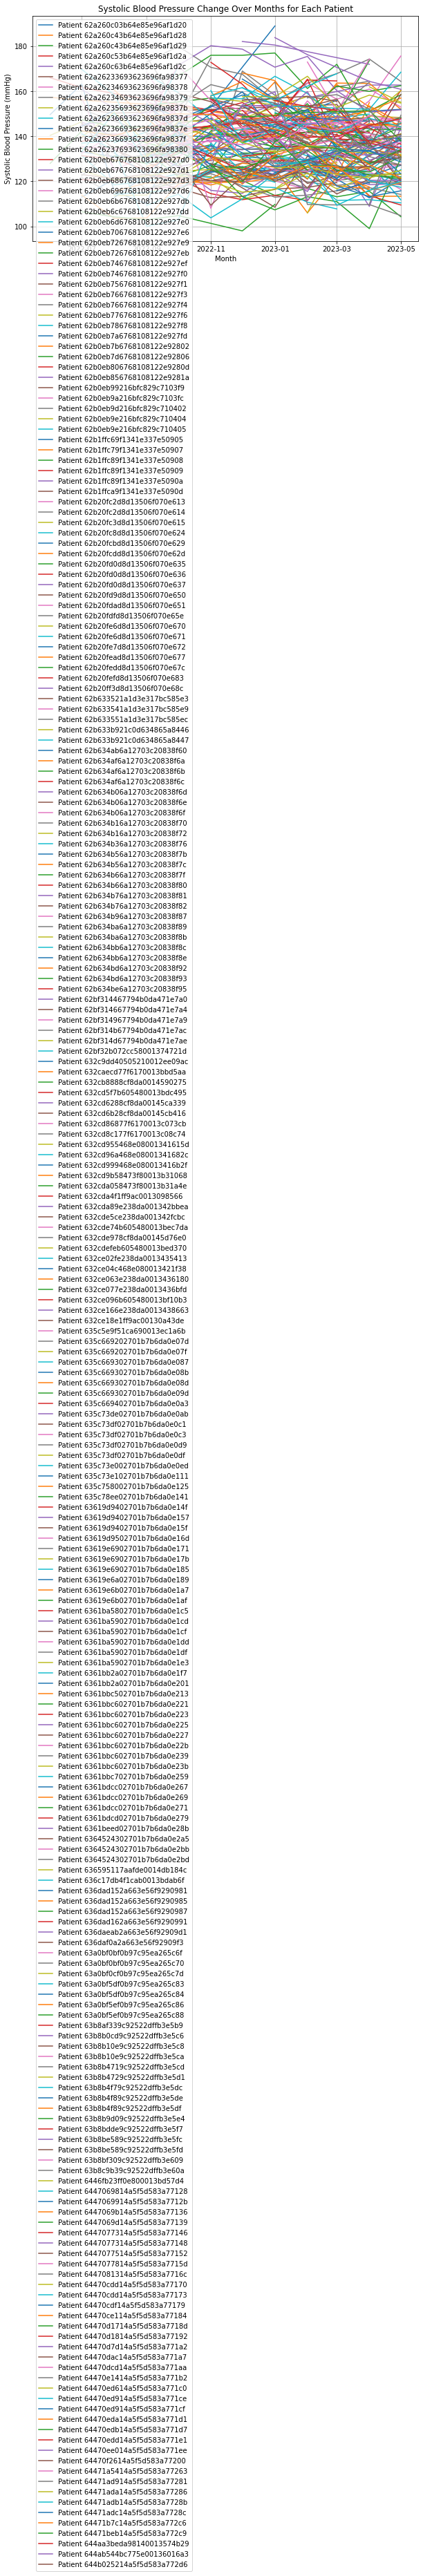

In [19]:
plt.figure(figsize=(10, 6))

# Get unique patient IDs
unique_patients = sample['memberId'].unique()

# Plot each patient's SBP over months
for patient_id in unique_patients:
    patient_data = sample[sample['memberId'] == patient_id]
    plt.plot(patient_data['month'], patient_data['systolic_mmHg'], label=f'Patient {patient_id}')

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Systolic Blood Pressure (mmHg)')
plt.title('Systolic Blood Pressure Change Over Months for Each Patient')
plt.legend()  # Show legend
plt.grid(True)  # Show gridlines
plt.tight_layout()

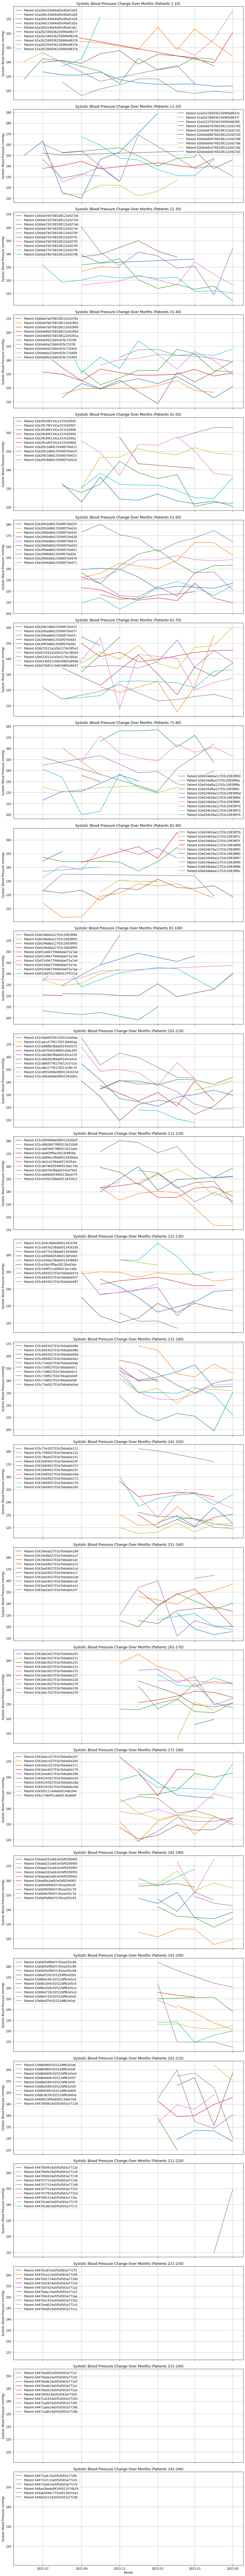

In [20]:
# Get unique patient IDs
unique_patients = sample['memberId'].unique()

# Define number of patients to display per subplot
patients_per_subplot = 10

# Calculate total number of subplots needed
num_subplots = -(-len(unique_patients) // patients_per_subplot)  # Ceil division

# Create subplots for each group of patients
fig, axs = plt.subplots(num_subplots, 1, figsize=(12, 5 * num_subplots), sharex=True)

# Plot each group of patients on separate subplots
for i in range(num_subplots):
    start_idx = i * patients_per_subplot
    end_idx = min((i + 1) * patients_per_subplot, len(unique_patients))

    # Select patients for this subplot
    patients_subset = unique_patients[start_idx:end_idx]

    # Plot each patient's SBP over months
    for patient_id in patients_subset:
        patient_data = sample[sample['memberId'] == patient_id]
        axs[i].plot(patient_data['month'], patient_data['systolic_mmHg'], label=f'Patient {patient_id}')

    # Adding labels and title for each subplot
    axs[i].set_ylabel('Systolic Blood Pressure (mmHg)')
    axs[i].set_title(f'Systolic Blood Pressure Change Over Months (Patients {start_idx + 1}-{end_idx})')
    axs[i].grid(True)
    axs[i].legend()

# Adding labels and title for the entire figure
plt.xlabel('Month')
plt.tight_layout()
plt.show()  # Display the plot

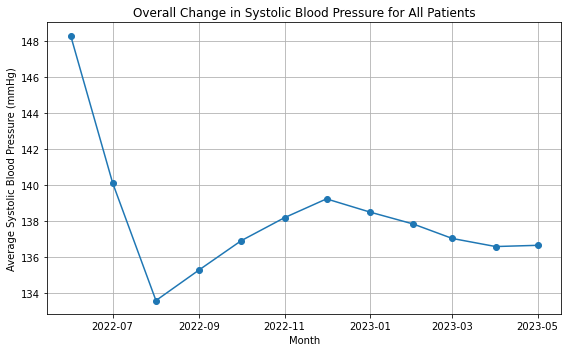

In [21]:


# Calculate average systolic blood pressure for each month across all patients
avg_sbp_per_month = sample.groupby('month')['systolic_mmHg'].mean()

# Plotting the overall change in blood pressure
plt.figure(figsize=(8, 5))

plt.plot(avg_sbp_per_month.index, avg_sbp_per_month.values, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Average Systolic Blood Pressure (mmHg)')
plt.title('Overall Change in Systolic Blood Pressure for All Patients')
plt.grid(True)
plt.tight_layout()


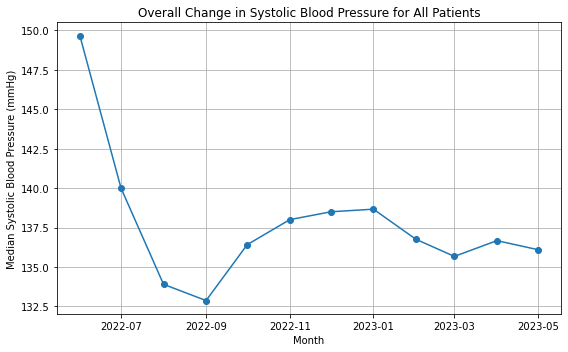

In [22]:
# Calculate average systolic blood pressure for each month across all patients
avg_sbp_per_month = sample.groupby('month')['systolic_mmHg'].median()

# Plotting the overall change in blood pressure
plt.figure(figsize=(8, 5))

plt.plot(avg_sbp_per_month.index, avg_sbp_per_month.values, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Month')
plt.ylabel('Median Systolic Blood Pressure (mmHg)')
plt.title('Overall Change in Systolic Blood Pressure for All Patients')
plt.grid(True)
plt.tight_layout()

## Detailed Questions

Based on the definition of BP category which takes patient’s BP readings from the latest day of a week. Firstly, since for every patient per week, he has several measurement records, so I **limited every patient's record to the latest day of a week per week**. Secondly, I **filtered out the rows that contained null systolic and diastolic values**.

In [109]:
# drop na values for systolic BP_mmHg and diastolic BP_mmHg columns
df.dropna(subset=["systolic BP_mmHg", "diastolic BP_mmHg"], inplace=True)

In [110]:
# Convert 'datetime_utc' column to datetime dtype
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])

# Get the day of the week (Monday=0, Sunday=6)
df['day_of_week'] = df['datetime_utc'].dt.dayofweek

# Get the #th of the week
df['number_of_week'] = df['datetime_utc'].dt.week

# get the year
df['year'] = df['datetime_utc'].dt.year

# find the latest measurement per week per patient
unique = df[["EPR ID", "datetime_utc", "number_of_week", "year", "day_of_week"]].groupby(["EPR ID", "number_of_week", "year"]).max().reset_index()
df = unique[["EPR ID", "datetime_utc"]].merge(df, on=["EPR ID", "datetime_utc"])


/var/folders/wp/6_zz4vgs79ndjls9bw_j54s80000gn/T/ipykernel_98719/1579467455.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['number_of_week'] = df['datetime_utc'].dt.week


In [111]:
# tag bp category
def BP_category(row):
    if (row['systolic BP_mmHg'] < 120) and (row['diastolic BP_mmHg'] < 80):
        return "Normal"
    elif (row['systolic BP_mmHg'] >= 120) and (row['systolic BP_mmHg'] <= 129) and (row['diastolic BP_mmHg'] < 80):
        return "Elevated"
    elif (row['systolic BP_mmHg'] > 180) or (row['diastolic BP_mmHg'] > 120):
        return "Hypertensive Crisis"
    elif ((row['systolic BP_mmHg'] >= 140) and (row['systolic BP_mmHg'] <= 180)) or ((row['diastolic BP_mmHg'] >= 90) and (row['diastolic BP_mmHg'] <= 120)):
        return "Hypertention Stage 2"
    elif ((row['systolic BP_mmHg'] >= 130) and (row['systolic BP_mmHg'] <= 139)) or ((row['diastolic BP_mmHg'] >= 80) and (row['diastolic BP_mmHg'] <= 89)):
        return "High Blood Pressure Stage 1"
    else:
        return "Others"

df['bp_category'] = df.apply(BP_category, axis=1)

In [121]:
# tag bp controlled
df["bp_controlled"] = df["bp_category"].apply(lambda x: "Uncontrolled" if (x == "Hypertensive Crisis") or (x == "Hypertention Stage 2") else "Controlled")

                     

### 1.	How many months needed for patient from uncontrolled to controlled?

**Assumption**: There are patients who are still categorized as uncontrolled after treatment. So we exclude data points of those patients and calculated the average months needed for patient from uncontrolled to controlled.

In [127]:
df

,EPR ID,datetime_utc,Enrolled Tasks,age_range,Gender,Is Still Enrolled,_id,timezone_local,date_local,type,...,bg_mmol,meal_type,before_meal,body_weight,weight_change_kg,day_of_week,number_of_week,year,bp_category,bp_controlled
0,62acbe2396f015001286cd92,2022-06-24 15:34:27,"BP, HS",40-44,M,0.0,10346674.0,America/Los_Angeles,2022-06-24,BP,...,NaN,NaN,NaN,NaN,NaN,4,25,2022,Hypertention Stage 2,Uncontrolled
1,62acbe2396f015001286cd92,2022-07-02 14:36:52,"BP, HS",40-44,M,0.0,10512112.0,America/Los_Angeles,2022-07-02,BP,...,NaN,NaN,NaN,NaN,NaN,5,26,2022,Hypertention Stage 2,Uncontrolled
2,62b0bf4a859f85001452d9df,2023-01-20 21:23:42,"BP, HS",60-64,F,1.0,13735015.0,America/Los_Angeles,2023-01-20,BP,...,NaN,NaN,NaN,NaN,NaN,4,3,2023,Hypertention Stage 2,Uncontrolled
3,62b0bf4a859f85001452d9df,2023-01-24 00:27:03,"BP, HS",60-64,F,1.0,13775347.0,America/Los_Angeles,2023-01-23,BP,...,NaN,NaN,NaN,NaN,NaN,1,4,2023,Hypertention Stage 2,Uncontrolled
4,62b0bf4a859f85001452d9df,2023-02-01 04:08:58,"BP, HS",60-64,F,1.0,14041030.0,America/Los_Angeles,2023-01-31,BP,...,NaN,NaN,NaN,NaN,NaN,2,5,2023,Hypertention Stage 2,Uncontrolled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3805,646d1b88576e390014392a33,2023-05-30 16:27:54,"BP, HS, BG",60-64,F,1.0,18989611.0,America/Los_Angeles,2023-05-30,BP,...,NaN,NaN,NaN,NaN,NaN,1,22,2023,Normal,Controlled
3806,646e3c91bc775e001382de30,2023-05-28 17:07:17,"BP, HS",70-74,F,1.0,17520202.0,America/Los_Angeles,2023-05-28,BP,...,NaN,NaN,NaN,NaN,NaN,6,21,2023,Hypertention Stage 2,Uncontrolled
3807,646e3c91bc775e001382de30,2023-06-01 10:24:21,"BP, HS",70-74,F,1.0,19164499.0,America/Los_Angeles,2023-06-01,BP,...,NaN,NaN,NaN,NaN,NaN,3,22,2023,Hypertention Stage 2,Uncontrolled
3808,646e7b1dbf15580013344eac,2023-05-27 13:14:24,"BP, HS",70-74,M,1.0,17479912.0,America/Los_Angeles,2023-05-27,BP,...,NaN,NaN,NaN,NaN,NaN,5,21,2023,High Blood Pressure Stage 1,Controlled


In [123]:
df.groupby(["EPR ID", "bp_controlled"]).count().reset_index()["EPR ID"].value_counts()

636aa2a2f9469d0013236995    2
632de134f045f0001330c73b    2
64557a9eff0e800013c89840    2
636aa2700cabce00137cb4e5    2
62b0bf4a859f85001452d9df    2
                           ..
636c1daa7aafde0014206a49    1
636c18300cabce001397b377    1
636aa236f9469d0013235afb    1
6362e5720cabce00132c7d88    1
646e7b1dbf15580013344eac    1
Name: EPR ID, Length: 258, dtype: int64